In [9]:
from PIL import Image
import colorsys
import subprocess 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas


## Generación de prueba

In [4]:
def preparar_img(name):
    img = Image.open(os.path.join(image_path,name)).convert("L")
    width, height = img.size
    data = ""
    imgdata = list(img.getdata())
    for i in range(0,height):        
        indexes = range(i*width,i*width+width)
        data = data + " ".join([str(imgdata[x]) for x in indexes]) + "\n"
    input_text = f"{height} {width}\n{data}"
    return (height, width, input_text, img)
# def correr(image_name, k, metodo):
#     datos_img = preparar_img(image_name)
#     completado = subprocess.run(["../../Resolucion/bin/ej1", f"{metodo}", f"{k}"], stdout=subprocess.PIPE, input=datos_img[2], universal_newlines=True)
#     if completado.returncode != 0:
#         print(f"ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={k} metodo={metodo}")

## Experimento 1: Tiempo de ejecución según valor de K

In [5]:
image_path = "../datos_entrada/ej1/"
csvFileName="./ej1_tiempos.csv"
testCases="testCases.in"
test_times = 10
images = {
        "test1.jpg": None
}
methods = [0,1,2]

kRange = range(500,6001,500)
for path in images:
    images[path] = preparar_img(path)  

In [6]:
for k in kRange:
    for m in methods:
        for imgName,imgData in images.items():
            completado = subprocess.run(["../../Resolucion/bin/ej1", f"{m}", f"{k}", f"{imgName}"], stdout=subprocess.PIPE, input=imgData[2], universal_newlines=True)
            if completado.returncode != 0:
                print(f"ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={k} metodo={metodo}")

In [56]:
csv = pandas.read_csv(csvFileName)


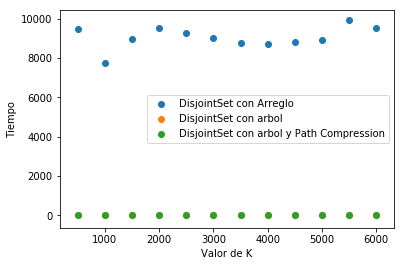

In [57]:
plt.clf()
for method in csv["Metodo"].unique():
    methodResults = csv[csv["Metodo"]==method]
    resultsByK = [np.median(methodResults[methodResults["k"] == k]["Tiempo"]) for k in kRange]
    plt.scatter(kRange,resultsByK,label=method)


plt.legend();
plt.xlabel("Valor de K")
plt.ylabel("Tiempo");


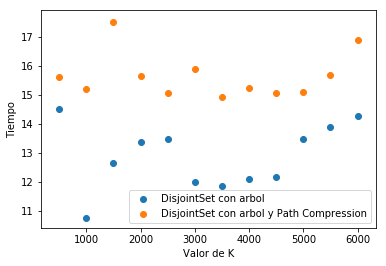

In [58]:
plt.clf()
for method in csv["Metodo"].unique():
    if method != "DisjointSet con Arreglo":
        methodResults = csv[csv["Metodo"]==method]
        resultsByK = [np.median(methodResults[methodResults["k"] == k]["Tiempo"]) for k in kRange]
        plt.scatter(kRange,resultsByK,label=method)


plt.legend();
plt.xlabel("Valor de K")
plt.ylabel("Tiempo");


### HABRIA QUE AGREGAR UN GRAFICO DE CORRELACION?

## Experimento 2: Tiempo de ejecución según tamaño de la imagen

### Considerando DisjointSet con Arreglo

In [93]:
image_path = "../datos_entrada/ej1/"
csvFileName="./ej1_tiempos.csv"
testCases="testCases.in"
test_times = 10
images = {
        "sintetico_1_320x180.png": None,
        #"sintetico_1_640x360.png": None,
        #"sintetico_1_1280x720.png": None,
        #"sintetico_1_1920x1080.png": None,
}
methods = [0,1,2]

k = 500
for path in images:
    images[path] = preparar_img(path)

In [48]:
for m in methods:
    for imgName,imgData in images.items():
        completado = subprocess.run(["../../Resolucion/bin/ej1", f"{m}", f"{k}", f"{imgName}"], stdout=subprocess.PIPE, input=imgData[2], universal_newlines=True)
        if completado.returncode != 0:
            print(f"ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={k} metodo={metodo}")

In [90]:
csv = pandas.read_csv(csvFileName)

DisjointSet con Arreglo [5665.46]
DisjointSet con arbol [14.5131]
DisjointSet con arbol y Path Compression [14.0749]


([<matplotlib.axis.XTick at 0x7f24a8f07390>],
 <a list of 1 Text xticklabel objects>)

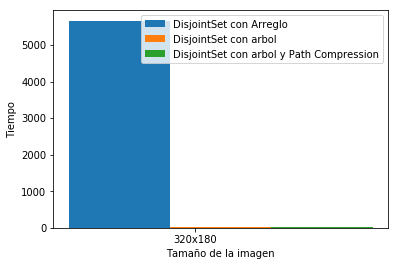

In [91]:
plt.clf()

metodos = csv["Metodo"].unique()
tiempos = {}
for file in images.keys():
    data_x_file = csv[csv["Filename"] == file]

    mediciones = {}
    for metodo in metodos:
        mediciones[metodo] = np.median(data_x_file[data_x_file["Metodo"] == metodo]["Tiempo"])
    tiempos[file] = mediciones
    
    
tiempos_x_metodos = {}    

for metodo in metodos:
    tiempos_x_metodos[metodo] = []
    for f in tiempos.keys():
        tiempos_x_metodos[metodo].append(tiempos[f][metodo])

i = 0
for k, v in tiempos_x_metodos.items():
    print(k, v)
    plt.bar([100*j+32*i for j in range(1, len(images.keys())+1)], v, width=32, label=k)
    i += 1

plt.legend();
plt.xlabel("Tamaño de la imagen")
plt.ylabel("Tiempo");
plt.xticks([100*j+24 for j in range(1, len(images.keys())+1)], ["320x180", "640x360", "1280x720"][:len(images.keys())])

Incluso en el caso de la imagen más chica(320x180) el metodo con DisjointSet con Arreglo tarda varios ordenes de magnitud más que los otros dos casos, por lo que de ahora en adelante vamos a descartarlo por ser demasiado lento.

### Sin considerar DisjointSet con Arreglo

In [98]:
image_path = "../datos_entrada/ej1/"
csvFileName="./ej1_tiempos.csv"
testCases="testCases.in"
test_times = 10
images = {
        "sintetico_1_320x180.png": None,
        "sintetico_1_640x360.png": None,
        "sintetico_1_1280x720.png": None,
        "sintetico_1_1920x1080.png": None,
}
methods = [1, 2]

k = 500
for path in images:
    images[path] = preparar_img(path)

In [99]:
for m in methods:
    for imgName,imgData in images.items():
        completado = subprocess.run(["../../Resolucion/bin/ej1", f"{m}", f"{k}", f"{imgName}"], stdout=subprocess.PIPE, input=imgData[2], universal_newlines=True)
        if completado.returncode != 0:
            print(f"ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={k} metodo={metodo}")

In [100]:
csv = pandas.read_csv(csvFileName)

DisjointSet con arbol [9.92124, 37.332499999999996, 145.326, 297.644]
DisjointSet con arbol y Path Compression [12.2046, 51.11945, 224.74450000000002, 468.841]


([<matplotlib.axis.XTick at 0x7f24a89e7940>,
 <a list of 4 Text xticklabel objects>)

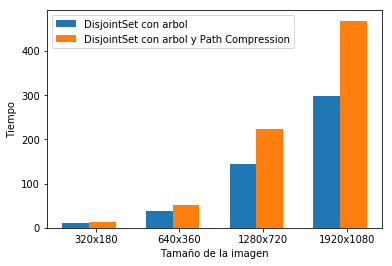

In [104]:
plt.clf()

metodos = [i for i in csv["Metodo"].unique() if i != "DisjointSet con Arreglo"]
tiempos = {}
for file in images.keys():
    data_x_file = csv[csv["Filename"] == file]

    mediciones = {}
    for metodo in metodos:
        mediciones[metodo] = np.median(data_x_file[data_x_file["Metodo"] == metodo]["Tiempo"])
    tiempos[file] = mediciones
    
    
tiempos_x_metodos = {}    

for metodo in metodos:
    tiempos_x_metodos[metodo] = []
    for f in tiempos.keys():
        tiempos_x_metodos[metodo].append(tiempos[f][metodo])

i = 0
for k, v in tiempos_x_metodos.items():
    print(k, v)
    plt.bar([100*j+32*i for j in range(1, len(images.keys())+1)], v, width=32, label=k)
    i += 1

plt.legend();
plt.xlabel("Tamaño de la imagen")
plt.ylabel("Tiempo");
plt.xticks([100*j+24 for j in range(1, len(images.keys())+1)], ["320x180", "640x360", "1280x720", "1920x1080"][:len(images.keys())])